# Multi-task without the label

Two tasks: y1, and y2.

Models:

* A on task y1
* B on task y2 
* C on task y1 and y2 with no task label
* D on task y1 and y2 but with x_enriched including task label and an embedding layer.


TLDR; Multi-task training without task labels requires task curation or luck. Don't do it. Including task labels and spend your time thinking about model capacity and generalizing error.

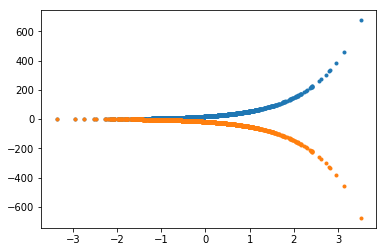

In [1]:
%matplotlib inline

import numpy as np
from pylab import *

m = 1000
d = 1

x = np.random.randn(m, 1)

def f(x):
    return np.exp(x + 3) - 2.0

y1 = f(x)
y2 = -y1

plot(x, y1, '.')
plot(x, y2, '.')

In [2]:
import tensorflow as tf

@tf.function
def loss(y_true, y_pred):
    return tf.reduce_mean((y_true - y_pred) ** 2)

def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='tanh'),
        tf.keras.layers.Dense(1),
        ]
    )
    optimizer = tf.optimizers.Adam(learning_rate=0.1)
    model.compile(optimizer=optimizer, loss=loss)
    return model

A = get_model()
B = get_model()
C = get_model()

A.fit(x=x, y=y1, epochs=10, verbose=1)
B.fit(x=x, y=y2, epochs=10, verbose=1)
C.fit(x=np.vstack([x, x]), y=np.vstack([y1, y2]), epochs=10, verbose=1)

W0728 14:35:01.788544 139903026804544 deprecation.py:323] From /home/cottrell/anaconda3/envs/37nightly/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1206: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0728 14:35:01.823119 139903026804544 deprecation.py:323] From /home/cottrell/anaconda3/envs/37nightly/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 0s 249us/sample - loss: 2329.0639
Epoch 2/10
1000/1000 [==============================] - 0s 25us/sample - loss: 1481.9178
Epoch 3/10
1000/1000 [==============================] - 0s 23us/sample - loss: 1081.6173
Epoch 4/10
1000/1000 [==============================] - 0s 25us/sample - loss: 845.3628
Epoch 5/10
1000/1000 [==============================] - 0s 23us/sample - loss: 709.1198
Epoch 6/10
1000/1000 [==============================] - 0s 25us/sample - loss: 603.8767
Epoch 7/10
1000/1000 [==============================] - 0s 25us/sample - loss: 524.1808
Epoch 8/10
1000/1000 [==============================] - 0s 26us/sample - loss: 448.5922
Epoch 9/10
1000/1000 [==============================] - 0s 26us/sample - loss: 401.7363
Epoch 10/10
1000/1000 [==============================] - 0s 25us/sample - loss: 375.1302
Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 0s 80us/sample 

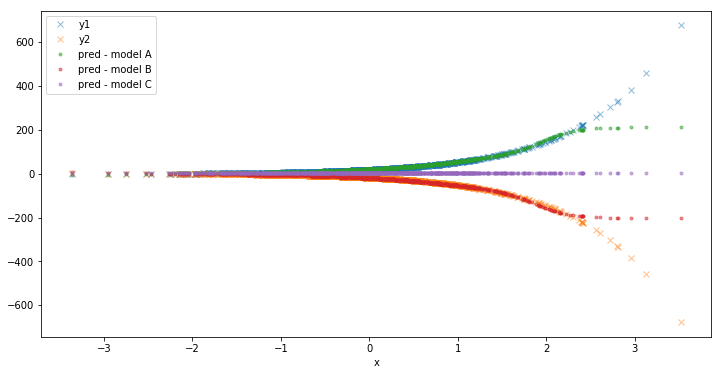

In [3]:
figure(figsize=(12, 6))
plot(x, y1, 'x', label='y1', alpha=0.5)
plot(x, y2, 'x', label='y2', alpha=0.5)
plot(x, A.predict(x), '.', label='pred - model A', alpha=0.5)
plot(x, B.predict(x), '.', label='pred - model B', alpha=0.5)
plot(x, C.predict(x), '.', label='pred - model C', alpha=0.5)
xlabel('x')
legend()

# Multi-task with the label and a label embedding

In [4]:
n_tasks = 2
x_enriched = np.vstack([np.hstack([np.zeros_like(x) + i, x]) for i in range(n_tasks)])
y_stacked = np.vstack([y1, y2])

x_enriched.shape, y_stacked.shape

((2000, 2), (2000, 1))

In [5]:
class Model(tf.keras.models.Model):
    
    def __init__(self):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(2, 2)
        self._layers = [
            tf.keras.layers.Dense(16, activation='tanh'),
            tf.keras.layers.Dense(1),
        ]
        
    def call(self, x):
        task_label = x[:,0:1]
        data = x[:,1:]
        assert len(task_label.shape) == 2
        assert len(data.shape) == 2
        z = self.embedding(task_label)
        z = tf.squeeze(z, axis=1)
        assert len(z.shape) == 2
        z = tf.concat([z, data], axis=1)
        assert z.shape[1] == 3
        for layer in self.layers:
            z = layer(z)
        return z
    
optimizer = tf.optimizers.Adam(learning_rate=0.1)
D = Model()
D.compile(optimizer=optimizer, loss=loss)
D.fit(x_enriched, y_stacked, verbose=1, epochs=10)

Train on 2000 samples
Epoch 1/10
2000/2000 [==============================] - 0s 59us/sample - loss: 3092.0134
Epoch 2/10
2000/2000 [==============================] - 0s 27us/sample - loss: 2192.8902
Epoch 3/10
2000/2000 [==============================] - 0s 24us/sample - loss: 1334.6597
Epoch 4/10
2000/2000 [==============================] - 0s 26us/sample - loss: 978.9538
Epoch 5/10
2000/2000 [==============================] - 0s 24us/sample - loss: 740.1226
Epoch 6/10
2000/2000 [==============================] - 0s 27us/sample - loss: 549.7232
Epoch 7/10
2000/2000 [==============================] - 0s 26us/sample - loss: 493.6731
Epoch 8/10
2000/2000 [==============================] - 0s 26us/sample - loss: 435.6449
Epoch 9/10
2000/2000 [==============================] - 0s 25us/sample - loss: 378.6303
Epoch 10/10
2000/2000 [==============================] - 0s 26us/sample - loss: 303.9914


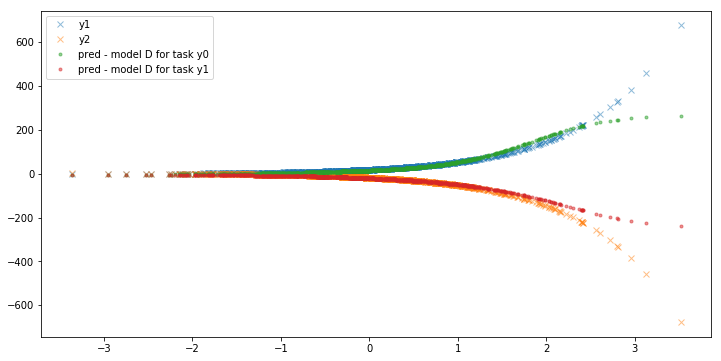

In [6]:
figure(figsize=(12, 6))
clf()
plot(x, y1, 'x', label='y1', alpha=0.5)
plot(x, y2, 'x', label='y2', alpha=0.5)
# plot(x, A.predict(x), '.', label='pred - model A', alpha=0.5)
# plot(x, B.predict(x), '.', label='pred - model B', alpha=0.5)
# plot(x, C.predict(x), '.', label='pred - model C', alpha=0.5)
for ii in range(2):
    i = x_enriched[:,0] == ii
    plot(x_enriched[i][:,1], D.predict(x_enriched[i]).squeeze(), '.', label=f'pred - model D for task y{ii}', alpha=0.5)

legend()